LOADING KSSL DATASET

---




### 1. Google Colab runtime setup [Optional]

In [1]:
# Clone and install spectrai package 
!git clone https://github.com/franckalbinet/spectrai.git 
!pip install /content/spectrai 

fatal: destination path 'spectrai' already exists and is not an empty directory.
Processing ./spectrai
  Created wheel for spectrai: filename=spectrai-0.0.3-cp36-none-any.whl size=11341 sha256=2b093929f28941ce574d77dcc8694153687bf93ed59f532d038e705ff66ca1f9
  Stored in directory: /tmp/pip-ephem-wheel-cache-zaksa0kz/wheels/ce/f8/30/d882013151d637a2b72fc00507c7f06e3dd23a193cb12dd965
Successfully built spectrai
  Found existing installation: spectrai 0.0.3
    Uninstalling spectrai-0.0.3:
      Successfully uninstalled spectrai-0.0.3


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Prepare /root folder content
!cp -r /content/drive/My\ Drive/Colab\ Notebooks/data/data_spectrai /root

In [11]:
# Create configuration file
!mkdir /root/.spectrai_config & cp /content/spectrai/config.toml /root/.spectrai_config

### 2. Import packages

In [2]:
from spectrai.datasets.kssl import (get_tax_orders_lookup_tbl, get_analytes,
                                    load_data, count_spectra_by_analytes,
                                    load_analytes, load_fact_tbl, load_spectra)
from spectrai.vis.spectra import (plot_spectra)
import pandas as pd

%load_ext autoreload
%autoreload 2

### 3. Load KSSL dataset

In [13]:
# Identify the analyte of interest
get_analytes('otassi')

,analyte_id,analyte_name,analyte_abbrev,uom_abbrev
63,78,"Potassium, Neutral Salt Extractable",k_neutral_salt,cmol(+)/kg
69,84,"Potassium, NH4OAc Extractable",k_nh4,cmol(+)/kg
229,218,"Potassium Feldspar, petro_count",min_FK_petro_count,count
350,675,"Potassium, Major Element",k_mjelm,mg/kg
428,379,"Potassium, Saturation Extract",k_satx,mmol(+)/L
454,406,"Potassium, Total",k_tot,% wt
509,464,"Potassium Feldspar, x-ray",min_FK_x-ray,peak_size
527,725,"Potassium, NH4OAc Extractable, 2M KCl displace...",k_nh4d,cmol(+)/kg
606,1065,"Potassium, Element Mehlich3 Extractable",k_el_meh3,mg/kg
638,1167,"Potassium, Water Extractable",k_watx,µg/kg


In [ ]:
%%time
# Loading Potassium, NH4OAc
X, X_names, y, y_names, instances_id = load_data([725])

CPU times: user 23 s, sys: 3.58 s, total: 26.6 s
Wall time: 27.1 s


In [ ]:
print('X shape: ', X.shape)
print('X approx. memory size: {} MB'.format(X.nbytes // 10**6))
print('y approx. memory size: {} MB'.format(y.nbytes // 10**6))
print('Wavenumbers: ', X_names)
print('Target variable: ', y_names)

X shape:  (50714, 1764)
X approx. memory size: 357 MB
y approx. memory size: 1 MB
Wavenumbers:  [3999 3997 3995 ...  603  601  599]
Target variable:  ['lay_depth_to_top' 'order_id' 'calc_value']


### 4. Plotting spectra

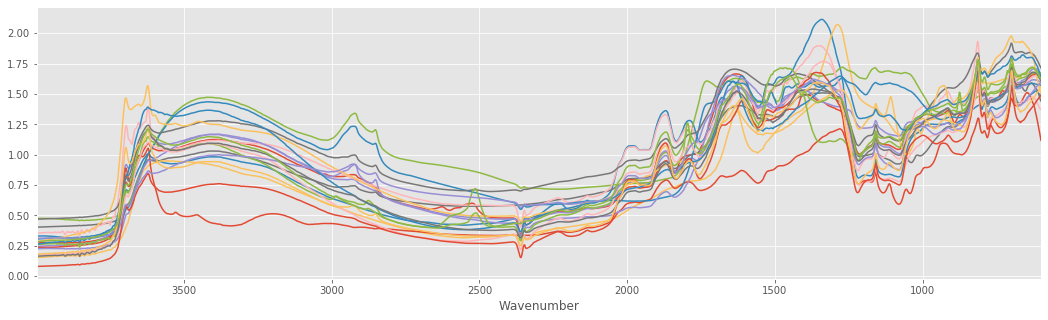

In [ ]:
# Quick plot of some spectra
plot_spectra(X, X_names, sample=20)

### 5. Dataset size (with MIRS)  available by analytes

In [ ]:
count_spectra_by_analytes(like='otas')

,dataset_size
analyte_name,
"Potassium, NH4OAc Extractable, 2M KCl displacement",50700
"Potassium, Saturation Extract",8105
"Potassium Feldspar, petro_count",4409
"Potassium, Element Mehlich3 Extractable",1585
"Potassium, NH4OAc Extractable",1340
"Potassium, Water Extractable",783
"Potassium, Major Element",7


In [21]:
df_analytes = load_analytes()
df_analytes.head()

,analyte_id,analyte_name,analyte_abbrev,uom_abbrev
0,1,"Aggregate Stability, 0.5-2mm Aggregates",aggstb,% wt
1,2,"Liquid Limit, Atterberg",abgll,% H2O
2,3,"Plastic Limit, Atterberg",abgpl,% H2O
3,4,"Bulk Density, <2mm Fraction, 1/3 Bar",db_13b,g/cc
4,5,"Bulk Density, <2mm Fraction, Ovendry",db_od,g/cc


In [22]:
# How many analytes in KSSL database?
df_analytes.shape

(956, 4)

In [23]:
df_analytes['analyte_id'].isin([622])

0      False
1      False
2      False
3      False
4      False
       ...  
951    False
952    False
953    False
954    False
955    False
Name: analyte_id, Length: 956, dtype: bool

In [24]:
df_analytes[df_analytes['analyte_id'].isin([622, 623, 624])]

,analyte_id,analyte_name,analyte_abbrev,uom_abbrev
314,622,"Carbon, Total NCS",c_tot_ncs,% wt
315,623,"Nitrogen, Total NCS",n_tot_ncs,% wt
316,624,"Sulfur, Total NCS",s_tot_ncs,% wt


In [25]:
df_fact = load_fact_tbl()

In [26]:
df_fact.head()

,lay_id,lims_pedon_id,lims_site_id,lay_depth_to_top,smp_id,analyte_id,calc_value
0,587,120,121,28.0,26473,268,5.490000
1,587,120,121,28.0,26473,481,4.670000
2,587,120,121,28.0,26473,420,1.040755
3,587,120,121,28.0,26473,417,3.951368
4,587,120,121,28.0,26473,88,4.526036


In [27]:
df_spectra = load_spectra().iloc[:, [0]]

In [28]:
df_spectra.head()

,smp_id
0,41455
1,41456
2,41457
3,41458
4,41459


In [31]:
df_fact.loc[:, ['lay_id', 'analyte_id', 'smp_id', 'lay_depth_to_top']].head()

,lay_id,analyte_id,smp_id
0,587,268,26473
1,587,481,26473
2,587,420,26473
3,587,417,26473
4,587,88,26473


In [29]:
df = pd.merge(df_fact.loc[:, ['lay_id', 'analyte_id', 'smp_id', 'lay_depth_to_top']],
              df_spectra, on='smp_id')

In [30]:
df.head()

,lay_id,analyte_id,smp_id,lay_depth_to_top
0,587,268,26473,28.0
1,587,481,26473,28.0
2,587,420,26473,28.0
3,587,417,26473,28.0
4,587,88,26473,28.0


In [31]:
df_count = df \
        .groupby('analyte_id') \
        .count()[['lay_id']] \
        .rename(columns={'lay_id': 'dataset_size'}) \
        .sort_values(by='dataset_size', ascending=False) \


In [40]:
df_count_with_names = pd.merge(df_count, df_analytes[['analyte_id', 'analyte_name']], on='analyte_id')

In [41]:
df_count_with_names.head()

,analyte_id,dataset_size,analyte_name
0,622,72562,"Carbon, Total NCS"
1,623,72561,"Nitrogen, Total NCS"
2,624,72559,"Sulfur, Total NCS"
3,420,72135,"Ratio, Air-dry/Ovendry"
4,1424,58224,"Carbonate, MIR predicted, unscreened"


In [38]:
df_count_with_names.to_excel('kssl_nb_sample_by_analyte.xls')

In [42]:
X, X_names, y, y_names, instances_id = load_data([622, 623])

In [43]:
X.shape

(50714, 1764)

In [44]:
y_names

array(['lay_depth_to_top', 'order_id', 'calc_value'], dtype=object)

In [45]:
y.shape

(50714, 3)